In [1]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ravdess = "/content/drive/MyDrive/Colab Notebooks/speech-emotion/dataset/ravdess/"
# ravdess_directory_list = os.listdir(Ravdess)
# for dir in ravdess_directory_list:
#   print(dir)

In [3]:
Ravdess = "/content/drive/MyDrive/Colab Notebooks/speech-emotion/dataset/ravdess/"
Savee = "/content/drive/MyDrive/Colab Notebooks/speech-emotion/dataset/SAVEE/AudioData/"

In [4]:
##create dataframe: column1=emotion, column2 = audio path
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()


,Emotions,Path
0,neutral,/content/drive/MyDrive/Colab Notebooks/speech-...
1,neutral,/content/drive/MyDrive/Colab Notebooks/speech-...
2,calm,/content/drive/MyDrive/Colab Notebooks/speech-...
3,neutral,/content/drive/MyDrive/Colab Notebooks/speech-...
4,calm,/content/drive/MyDrive/Colab Notebooks/speech-...


In [5]:
data_path = Ravdess_df

<ipython-input-25-fc5d26044355>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Emotions', data=data_path, palette=palette)


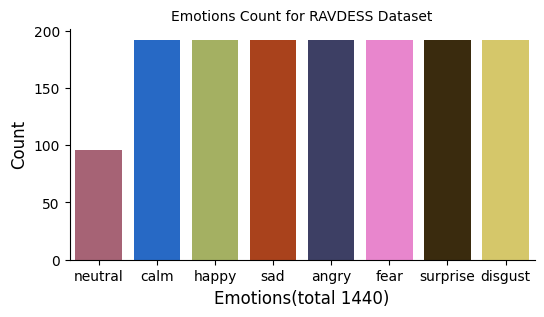

In [25]:
## count of emotions
random_colors = np.random.rand(8, 3)
color_mapping = dict(zip(data_path.Emotions.unique(), random_colors))
palette = sns.color_palette([color_mapping[emotion] for emotion in data_path.Emotions.unique()])

plt.figure(figsize=(6, 3))
plt.title('Emotions Count for RAVDESS Dataset', size=10)
sns.countplot(x='Emotions', data=data_path, palette=palette)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions(total 1440)', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
## sample audio for each emotions
emotions = data_path.Emotions.unique()
for emotion in emotions:
    path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
    data, sr = librosa.load(path)
    print(f"Playing audio for emotion {emotion}")
    display(Audio(data=data, rate=sr))

Playing audio for emotion neutral


Playing audio for emotion calm


Playing audio for emotion happy


Playing audio for emotion sad


Playing audio for emotion angry


Playing audio for emotion fear


Playing audio for emotion surprise


Playing audio for emotion disgust


In [28]:
emotion_list = []
path_list = []
savee_directory_list = os.listdir(Savee)

for dir in savee_directory_list:
    actor = os.listdir(Savee + dir)
    for audio_file in actor:
        emo = audio_file[:-6]
        emotion_list.append(emo)
        path_list.append(Savee + dir + '/' + audio_file)


# Create temporary dataframe for emotion
emotion_df = pd.DataFrame(emotion_list, columns=['Emotions'])
# Create temporary dataframe for File Path
path_df = pd.DataFrame(path_list, columns=['Path'])
# Combine above two dataframes to get final dataframe
Savee_df = pd.concat([emotion_df, path_df], axis=1)
emotion_map = {
    'n': 'neutral',
    'h': 'happy',
    'sa': 'sad',
    'a': 'angry',
    'f': 'fear',
    'd': 'disgust',
    'su': 'surprise'
}
Savee_df.Emotions.replace(emotion_map, inplace=True)
Savee_df.head()

,Emotions,Path
0,angry,/content/drive/MyDrive/Colab Notebooks/speech-...
1,angry,/content/drive/MyDrive/Colab Notebooks/speech-...
2,angry,/content/drive/MyDrive/Colab Notebooks/speech-...
3,angry,/content/drive/MyDrive/Colab Notebooks/speech-...
4,fear,/content/drive/MyDrive/Colab Notebooks/speech-...


<ipython-input-36-e985d0bf1337>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Emotions', data=Savee_df, palette=palette)


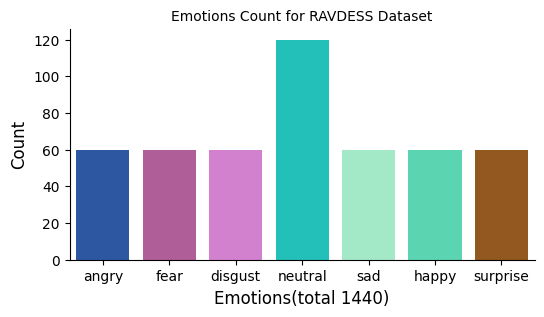

In [36]:
## count of emotions
random_colors = np.random.rand(7, 3)
color_mapping = dict(zip(Savee_df.Emotions.unique(), random_colors))
palette = sns.color_palette([color_mapping[emotion] for emotion in Savee_df.Emotions.unique()])

plt.figure(figsize=(6, 3))
plt.title('Emotions Count for RAVDESS Dataset', size=10)
sns.countplot(x='Emotions', data=Savee_df, palette=palette)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions(total 1440)', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

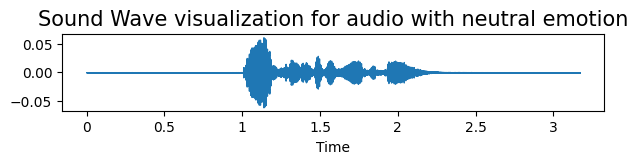

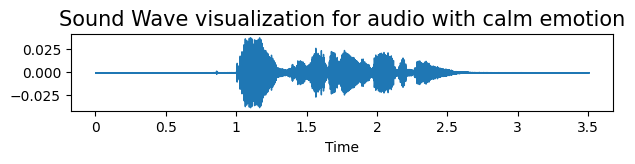

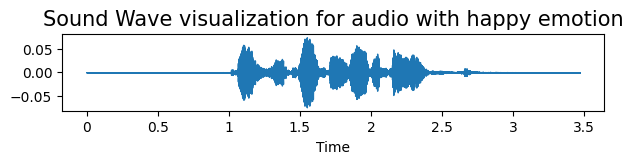

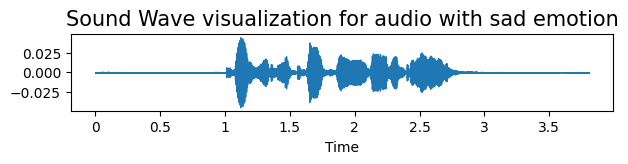

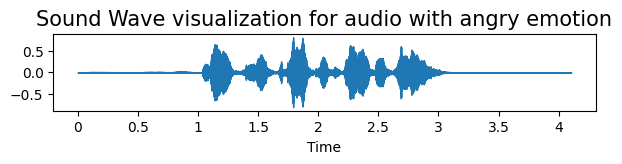

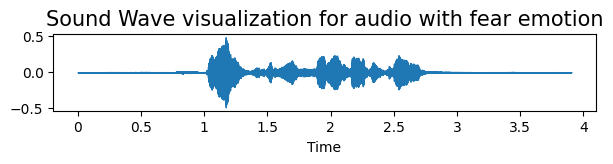

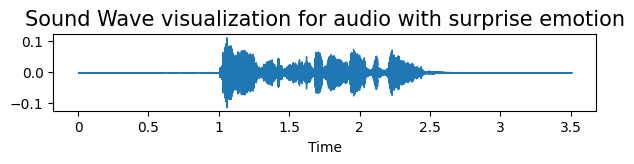

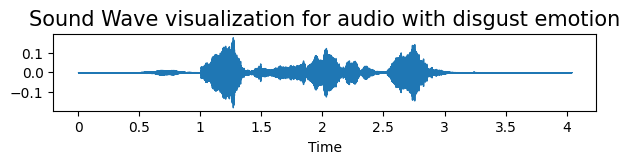

In [ ]:
### show wave form
def create_waveplot(data, sr, e):
    plt.figure(figsize=(7, 1))
    plt.title('Sound Wave visualization for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

emotions = data_path.Emotions.unique()
for emotion in emotions:
    path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)

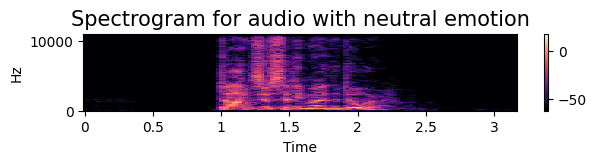

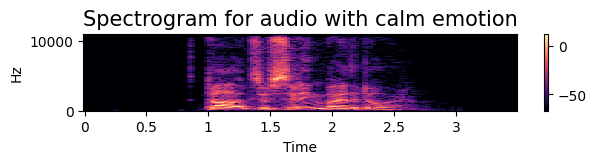

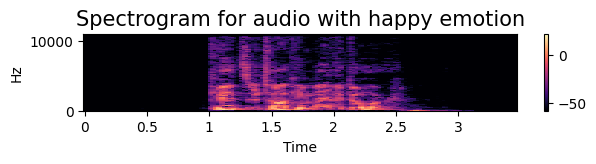

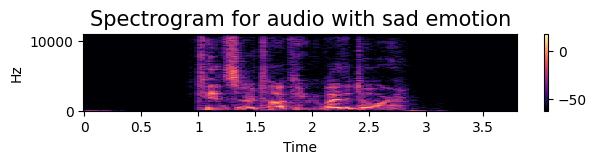

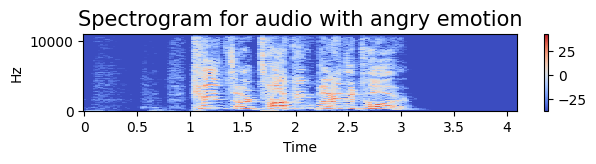

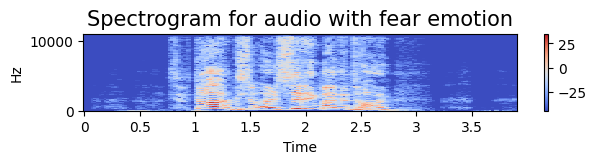

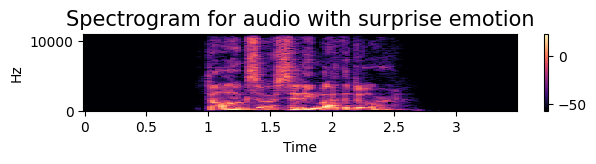

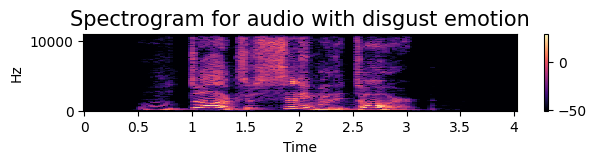

In [ ]:
## show spectogram
def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(7, 1))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

emotions = data_path.Emotions.unique()
for emotion in emotions:
    path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
    data, sampling_rate = librosa.load(path)
    create_spectrogram(data, sampling_rate, emotion)

In [ ]:
print(data_path.Path.shape)

(1440,)


In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    rate=0.8
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)


In [ ]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2))

    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3))
    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

len(X), len(Y), data_path.Path.shape


(4320, 4320, (1440,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.321275,0.729664,0.750033,0.730624,0.735275,0.713529,0.660531,0.684966,0.733049,0.753972,...,4.310902e-06,3.291511e-06,2.148075e-06,2.279739e-06,5.116492e-06,8.190280e-06,0.000007,0.000005,4.245835e-07,neutral
1,0.280405,0.735664,0.787840,0.764382,0.765904,0.778799,0.711996,0.655775,0.700458,0.733820,...,5.670649e-06,4.633848e-06,3.755750e-06,3.736373e-06,6.642892e-06,9.709461e-06,0.000008,0.000007,2.138170e-06,neutral
2,0.188227,0.622090,0.699117,0.753257,0.721177,0.701753,0.682364,0.662857,0.686512,0.734021,...,8.577035e-07,9.576477e-07,7.733598e-07,5.233060e-07,3.593583e-07,9.267893e-07,0.000002,0.000001,7.754233e-08,neutral
3,0.323342,0.741108,0.752256,0.744445,0.732210,0.735576,0.684238,0.673684,0.699704,0.733065,...,1.982246e-05,1.854489e-05,2.479384e-05,8.005070e-05,4.002139e-05,3.728482e-05,0.000040,0.000023,1.570475e-06,neutral
4,0.320462,0.815183,0.802043,0.790349,0.816812,0.812900,0.716838,0.694803,0.748886,0.763827,...,6.495307e-05,5.820067e-05,6.840338e-05,1.233061e-04,8.242396e-05,8.186309e-05,0.000084,0.000065,4.099861e-05,neutral
